# An Investigation of NASA's Kepler Objects of Interest (KOI) Dataset

## Summary

This project includes an explortaory data analysis and a machine learning classification task (work in progress!) of NASA's [KOI Table](https://exoplanetarchive.ipac.caltech.edu/cgi-bin/TblView/nph-tblView?app=ExoTbls&config=cumulative).

### Questions of Interest

- How many exoplanets are confirmed, candidates, and false positives?
- How are planet sizes distributed? Do we see more Earth-sized, Uranas-sized, or Jupiter-sized planets?
- Is there a relationship between planet size and orbital period?
- Is there a correlation between planet equilibrium temperature and star temperature?
- How does planet size vary with stellar temperature (koi_steff) or stellar radius (koi_srad)?
- Which confirmed planets are most similar to Earth (based on radius, temperature, and orbital period)?

### Data Description

For a detailed description for every data column, NASA has provided [this page](https://exoplanetarchive.ipac.caltech.edu/docs/API_kepcandidate_columns.html). For this project, we will be focusing on the following columns:

| Database Column Name | Short Description |
|----------------------|-------------------|
| kepid | Target identification number |
| kepoi_name | A number used to identify and track a Kepler Object of Interest (KOI) |
| kepler_name | Kepler number name in the form "Kepler-N," plus a lower-case letter, identifying the planet |
| koi_disposition |The category of this KOI from the Exoplanet Archive. Current values are **CANDIDATE**, **FALSE POSITIVE**, **NOT DISPOSITIONED** or **CONFIRMED** |
| koi_score | A value between 0 and 1 that indicates the confidence in the KOI disposition. For CANDIDATEs, a higher value indicates more confidence in its disposition, while for FALSE POSITIVEs, a higher value indicates less confidence in that disposition |
| koi_period | The interval between consecutive planetary transits (days) |
| koi_prad | The radius of the planet (Earth radii) |
| koi_teq | Approximation for the temperature of the planet (Kelvin) |
| koi_steff | The photospheric temperature of the star (Kelvin) |
| koi_srad | The photospheric radius of the star |
| koi_slogg | The base-10 logarithm of the acceleration due to gravity at the surface of the star (log<sub>10</sub>, cm/s<sup>2</sup>) |
| koi_kepmag | The Kepler-band magnitude, brightness of the star as observed by Kepler (mag) |

## Importing Libraries and User Functions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

In [2]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train a classification model, make predictions, and return evaluation metrics as a dictionary.

    Parameters
    ----------
    model : estimator object
        The classification model to train.
    X_train, X_test : array-like
        Feature matrices for training and testing.
    y_train, y_test : array-like
        Target labels for training and testing.
    model_name : str
        Name of the model for identification.

    Returns
    -------
    dict
        Dictionary containing model name, accuracy, weighted F1 score, and optionally confusion matrix.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return {
        "Model": model_name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1 Score (weighted)": f1_score(y_test, y_pred, average='weighted'),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

## Data Wrangling

In [3]:
cumulative = pd.read_csv('cumulative.csv', comment='#')
cumulative.head(5)

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,0,0,0,0,...,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,0,0,0,0,...,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,0,1,0,0,...,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,0,0,0,0,...,-211.0,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509


### Data Cleaning

Let's finally start exploring this dataset! We'll be looking to handle missing data, verify column dtypes, and reomve duplicate data.

In [4]:
cumulative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 49 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        2747 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          8054 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9110 non-null   float64
 12  koi_period_err2    9110 non-null   float64
 13  koi_time0bk        9564 non-null   float64
 14  koi_time0bk_err1   9110 non-null   float64
 15  koi_time0bk_err2   9110 non-null   float64
 16  koi_impact         9201 

In [5]:
# Get number of NaN values by column
cumulative.isna().sum()

kepid                   0
kepoi_name              0
kepler_name          6817
koi_disposition         0
koi_pdisposition        0
koi_score            1510
koi_fpflag_nt           0
koi_fpflag_ss           0
koi_fpflag_co           0
koi_fpflag_ec           0
koi_period              0
koi_period_err1       454
koi_period_err2       454
koi_time0bk             0
koi_time0bk_err1      454
koi_time0bk_err2      454
koi_impact            363
koi_impact_err1       454
koi_impact_err2       454
koi_duration            0
koi_duration_err1     454
koi_duration_err2     454
koi_depth             363
koi_depth_err1        454
koi_depth_err2        454
koi_prad              363
koi_prad_err1         363
koi_prad_err2         363
koi_teq               363
koi_teq_err1         9564
koi_teq_err2         9564
koi_insol             321
koi_insol_err1        321
koi_insol_err2        321
koi_model_snr         363
koi_tce_plnt_num      346
koi_tce_delivname     346
koi_steff             363
koi_steff_er

For columns of type `int` or `float64`, we will be imputing the columns' median. For columns of type `object`, we will impute the string 'Unknown'. The only columns that we will be dropping will be `koi_teq_err1` and `koi_teq_err2` because out of 9564 possible entries, all 9564 of them are NaN.

In [6]:
# Drop completely null columns
cumulative = cumulative.drop(['koi_teq_err1', 'koi_teq_err2'], axis=1)

In [7]:
# Replace NaNs in numeric columns with median
numeric_cols = cumulative.select_dtypes(include=['int64', 'float64']).columns
cumulative[numeric_cols] = cumulative[numeric_cols].fillna(cumulative[numeric_cols].median())

In [8]:
# Replace NaNs in object columns with 'Unknown'
obj_cols = cumulative.select_dtypes(include=['object']).columns
cumulative[obj_cols] = cumulative[obj_cols].fillna('Unknown')

In [9]:
# Print number of NaNs left
print(cumulative.isna().any().sum())

0


In [10]:
# Now that we've ensured no NaNs, title case the koi_disposition and koi_pdisposition columns
to_title = ['koi_disposition', 'koi_pdisposition']
cumulative[to_title] = cumulative[to_title].map(lambda s: s.title())

In [11]:
cumulative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9564 entries, 0 to 9563
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   kepid              9564 non-null   int64  
 1   kepoi_name         9564 non-null   object 
 2   kepler_name        9564 non-null   object 
 3   koi_disposition    9564 non-null   object 
 4   koi_pdisposition   9564 non-null   object 
 5   koi_score          9564 non-null   float64
 6   koi_fpflag_nt      9564 non-null   int64  
 7   koi_fpflag_ss      9564 non-null   int64  
 8   koi_fpflag_co      9564 non-null   int64  
 9   koi_fpflag_ec      9564 non-null   int64  
 10  koi_period         9564 non-null   float64
 11  koi_period_err1    9564 non-null   float64
 12  koi_period_err2    9564 non-null   float64
 13  koi_time0bk        9564 non-null   float64
 14  koi_time0bk_err1   9564 non-null   float64
 15  koi_time0bk_err2   9564 non-null   float64
 16  koi_impact         9564 

In [12]:
cumulative.sample(5, random_state=42)

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
9004,7537660,K06884.01,Unknown,Candidate,Candidate,0.334,0,0,0,0,...,-160.0,4.438,0.070,-0.128,1.000,0.251,-0.111,294.60150,43.159935,13.583
5028,3219037,K03395.01,Unknown,Candidate,Candidate,1.000,0,0,0,0,...,-175.0,4.453,0.098,-0.182,0.924,0.255,-0.127,286.54041,38.332600,14.634
1142,9729691,K01751.01,Kepler-949 b,Confirmed,Candidate,1.000,0,0,0,0,...,-163.0,4.447,0.120,-0.180,0.895,0.186,-0.129,298.60788,46.453678,14.548
1355,7697568,K01829.01,Unknown,False Positive,False Positive,0.000,0,1,0,0,...,-159.0,4.538,0.051,-0.119,0.826,0.153,-0.082,296.52243,43.363369,15.911
8740,9005854,K07121.01,Unknown,False Positive,False Positive,0.000,0,1,0,0,...,-159.0,4.589,0.035,-0.119,0.780,0.133,-0.061,285.03131,45.380451,15.569


---

## Exploratory Data Analysis

The main dataset has many columns, many of which we will not need to investigate in order to answer the questions of interest. Let's make a new subset table which will only include columns of interest.

In [13]:
ids = ['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition']
features = ['koi_score', 'koi_period', 'koi_prad', 'koi_teq', 'koi_steff', 'koi_srad', 'koi_slogg', 'koi_kepmag']
exo = cumulative[ids + features]
exo.head(5)

,kepid,kepoi_name,kepler_name,koi_disposition,koi_score,koi_period,koi_prad,koi_teq,koi_steff,koi_srad,koi_slogg,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,Confirmed,1.000,9.488036,2.26,793.0,5455.0,0.927,4.467,15.347
1,10797460,K00752.02,Kepler-227 c,Confirmed,0.969,54.418383,2.83,443.0,5455.0,0.927,4.467,15.347
2,10811496,K00753.01,Unknown,Candidate,0.000,19.899140,14.60,638.0,5853.0,0.868,4.544,15.436
3,10848459,K00754.01,Unknown,False Positive,0.000,1.736952,33.46,1395.0,5805.0,0.791,4.564,15.597
4,10854555,K00755.01,Kepler-664 b,Confirmed,1.000,2.525592,2.75,1406.0,6031.0,1.046,4.438,15.509


### How many exoplanets are confirmed, candidates, and false positives?

To find this, let's make a histogram and label each histogram with its respective height.

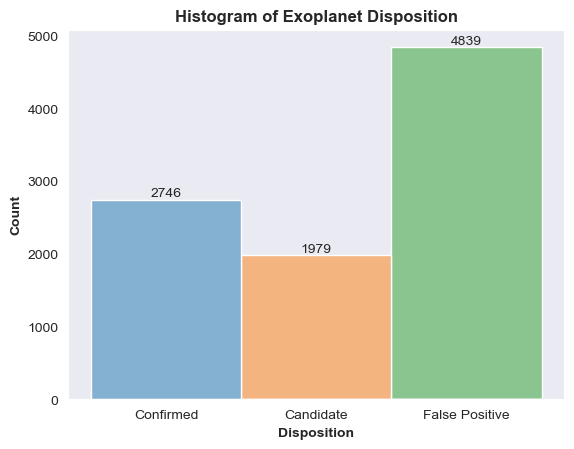

In [14]:
# Choose a style
sns.set_style('dark')

# Plot histogram
ax = sns.histplot(x='koi_disposition', data=exo, hue='koi_disposition', legend=False)

# Adjust title and axes
ax.set_title('Histogram of Exoplanet Disposition', fontweight='bold')
ax.set_xlabel('Disposition', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')

# Add counts on top of each 
for p in ax.patches:
    h = p.get_height()
    if h > 0:
        ax.text(
            x=p.get_x() + p.get_width() / 2,
            y=h,
            s=int(h),
            ha='center', va='bottom',
            fontsize=10
        )

plt.show()

In [15]:
disposition_norm = exo['koi_disposition'].value_counts(normalize=True)
print(disposition_norm)

koi_disposition
False Positive    0.505960
Confirmed         0.287118
Candidate         0.206922
Name: proportion, dtype: float64


We see that there are 4839 false positives, 2746 confirmed, and 1979 candidate exoplanets. Of the three, false positives are by far the most common at about 50.5%

### How are planet sizes distributed? Do we see more Earth-sized, Uranas-sized, or Jupiter-sized planets?

To look at the distribuation of plantet sizes, let's plot a histogram of the planet radii, `koi_prad`.

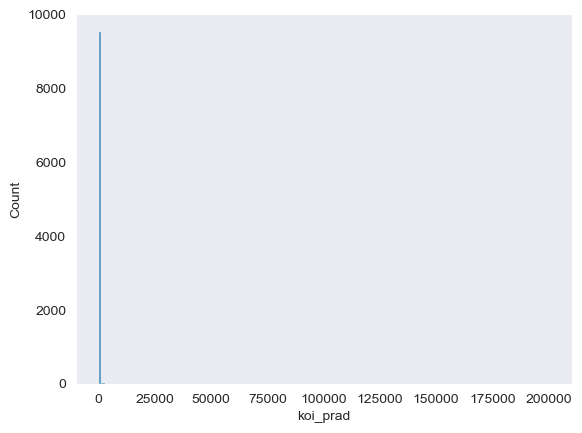

In [16]:
ax = sns.histplot(exo['koi_prad'])

Ok, this graph is not very usefull. Let's get more specific by looking at only confirmed exoplanets and ignoring outliers.

In [28]:
# Sort the planet radii of confirmed exoplanets only
confirmed_prads = exo.loc[exo['koi_disposition'] == 'Confirmed', 'koi_prad'].sort_values()

# Calculate the 1st and 3rd quartiles then calculate the interquartile range (IQR)
q1, q3, = confirmed_prads.quantile([0.25, 0.75])
iqr = q3 - q1

# Calculate the upper and lower bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
print('lower bound: ', lower_bound, '\nupper_bound: ', upper_bound)

# Mask for radii only within bounds
confirmed_prads_no_outliers = confirmed_prads.loc[(confirmed_prads > lower_bound) & (confirmed_prads < upper_bound)].to_frame()

lower bound:  -0.6049999999999998 
upper_bound:  5.035


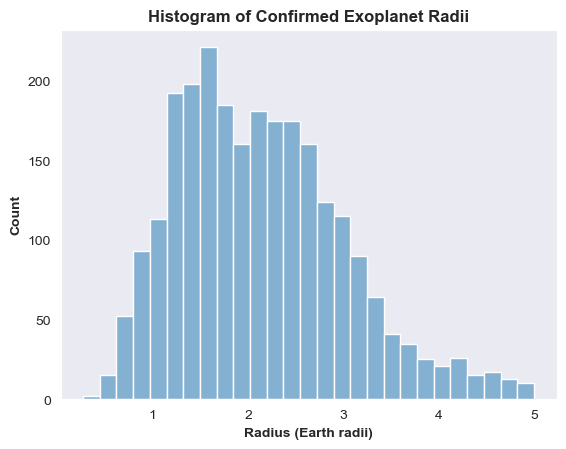

In [18]:
# Plot histogram
ax = sns.histplot(confirmed_prads_no_outliers, legend=False)

# Adjust title and axes
ax.set_title('Histogram of Confirmed Exoplanet Radii', fontweight='bold')
ax.set_xlabel('Radius (Earth radii)', fontweight='bold')
ax.set_ylabel('Count', fontweight='bold')

plt.show()

In [19]:
confirmed_prads_no_outliers.describe().T

,count,mean,std,min,25%,50%,75%,max
koi_prad,2518.0,2.139627,0.876877,0.27,1.46,2.04,2.68,5.0


We see that the vast majority of confirmed exoplanets are within 0 and 5 Earth radii (R🜨). For reference, Uranas is about 4 R🜨 and Jupiter is about 11 R🜨. Because our data is skewed right, the mean (2.14) is larger than the median (2.04) but both agree that the most common confirmed exoplanet radius is about 2 R🜨.

### Is there a relationship between planet size and orbital period? What about planet equilibrium temperature and star temperature?

We can make a correlation matrix which will answer these questions and also show us the relationships between all of our variables of interest.

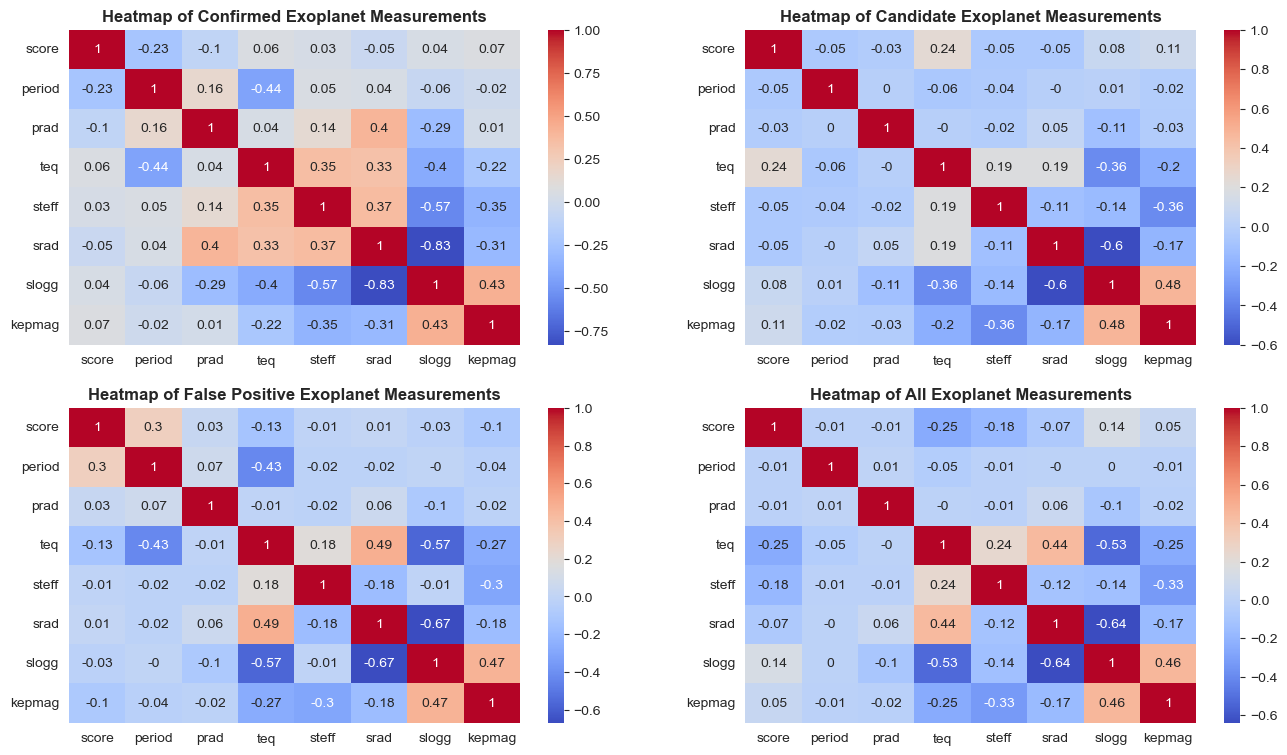

In [31]:
# Make labels which remove 'koi_' from column names
labels = [col.replace('koi_', '') for col in features]

fig, axes = plt.subplots(2, 2, figsize=(16, 9))

# First 3 heatmaps : by disposition
for dispo, ax in zip(exo['koi_disposition'].unique(), axes.flat):
    exo_values = exo.loc[exo['koi_disposition'] == dispo][features]
    corr = exo_values.corr().round(2)
    
    ax = sns.heatmap(corr, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(f'Heatmap of {dispo} Exoplanet Measurements', fontweight='bold')

# Last heatmap : combined
exo_values = exo[features]
corr = exo_values.corr().round(2)

axes[-1, -1] = sns.heatmap(corr, annot=True, cmap='coolwarm', xticklabels=labels, yticklabels=labels, ax=axes[-1, -1])
axes[-1, -1].set_title('Heatmap of All Exoplanet Measurements', fontweight='bold')

plt.show()

With this 2x2 grid of heatmaps, we can see the correlation of all varaibles by either individual disposition or all dispositions. In all four heatmaps, we see no correlation planet size and orbital period. For equilibrium temperature and star temperature, all have no correlation except for Confirmed which has a moderate relationship.

It is interesting to see how in the Confirmed heatmap, there are more weak positive relationships between measurements. For instance, stellar temperature and planet equilibrium temperature for confirmed exoplanets have a moderate correlation while no other disposition does.

---

## Classification Task

Let's start with the machine learning classification task.

In [21]:
# Make feature and target tables 
X = exo[features].drop(columns='koi_score')
y = exo['koi_disposition']     

# Encodes disposition labels into numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)       

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Features selection
selector = SelectKBest(score_func=f_classif, k=7)  # keep all features
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Convert to DataFrame with matching column names
X_train_selected_df = pd.DataFrame(X_train_selected, columns=X_train.columns[selector.get_support()])
X_test_selected_df = pd.DataFrame(X_test_selected, columns=X_train.columns[selector.get_support()])

In [22]:
# Models to fit for mulitclass classication
models_multi = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "MLP Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

In [23]:
results_multi = []

# Fit each model
for name, model in models_multi.items():
    metrics = evaluate_model(model, X_train_selected_df, X_test_selected_df, y_train, y_test, name)
    results_multi.append(metrics)

# Convert results to a DataFrame
results_df_m = pd.DataFrame(results_multi)

# Display without printing confusion matrix in the main table
results_df_multi = results_df_m.drop(columns="Confusion Matrix")
results_df_multi = results_df_multi.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
results_df_multi

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 7651, number of used features: 7
[LightGBM] [Info] Start training from score -1.575515
[LightGBM] [Info] Start training from score -1.247744
[LightGBM] [Info] Start training from score -0.681323


,Model,Accuracy,F1 Score (weighted)
0,XGBoost,0.733403,0.725905
1,LightGBM,0.732358,0.723153
2,Random Forest,0.728698,0.720642
3,Gradient Boosting,0.725562,0.716881
4,MLP Neural Network,0.674334,0.633708


Of the five models fitted, we see that XGBoost has the highest accuracy at 73%. However, we coult try to raise the accuracy by removing `Candidates`. This is because `Candidates` are simply unknown objects while `Confirmed` are obviously exoplanets, and `False Positive` are confirmed to not be exoplanets.

In [32]:
# Make feature and target tables
no_cand = exo.loc[exo['koi_disposition'] != 'Candidate']

X = no_cand[features].drop(columns='koi_score')
y = no_cand['koi_disposition']

# Encodes disposition labels into numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)       

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale numeric features to match proportions
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Features selection
selector = SelectKBest(score_func=f_classif, k=7)  # keep all features
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Convert to DataFrame with matching column names
X_train_selected_df = pd.DataFrame(X_train_selected, columns=X_train.columns[selector.get_support()])
X_test_selected_df = pd.DataFrame(X_test_selected, columns=X_train.columns[selector.get_support()])

In [25]:
# Models to fit for binary classicifaction
models_binary = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "MLP Neural Network": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
}

In [26]:
results_binary = []

# Fit each model
for name, model in models_binary.items():
    metrics = evaluate_model(model, X_train_selected_df, X_test_selected_df, y_train, y_test, name)
    results_binary.append(metrics)

# Convert results to a DataFrame
results_df_b = pd.DataFrame(results_binary)

# Display without printing confusion matrix in the main table
results_df_binary = results_df_b.drop(columns="Confusion Matrix")
results_df_binary = results_df_binary.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
results_df_binary

[LightGBM] [Info] Number of positive: 3871, number of negative: 2197
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 6068, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.637937 -> initscore=0.566420
[LightGBM] [Info] Start training from score 0.566420


,Model,Accuracy,F1 Score (weighted)
0,Gradient Boosting,0.885959,0.886881
1,LightGBM,0.883982,0.884454
2,Random Forest,0.879367,0.880120
3,XGBoost,0.877390,0.878213
4,MLP Neural Network,0.845748,0.845986


After adjusting the classification task from multiclass to binary, we see that the Gradient Boosting Model now preforms the best at about 90% accuracy!

---

## Conclusion

In this project, we conducted a comprehensive analysis of NASA’s Kepler exoplanet dataset to explore patterns among confirmed, candidate, and false positive exoplanets and to build predictive classification models.

Exploratory Data Analysis (EDA) revealed:
- Certain planetary and stellar features, such as radius, orbital period, and stellar flux, show distinct distributions across exoplanet classes.
- Correlations among features provided insight into which variables may be most predictive of confirmed exoplanets.
- The dataset is imbalanced, with fewer confirmed exoplanets relative to false positives, highlighting the importance of using metrics beyond simple accuracy.

Machine Learning Classification:

- Multiple models were trained and evaluated, including Random Forest, Gradient Boosting, XGBoost, LightGBM, and MLP Neural Networks.
- Feature selection helped identify the most informative variables while simplifying the models.
- Evaluation metrics, including accuracy and weighted F1 score, showed that ensemble methods such as XGBoost and Gradient Boosting performed best, effectively handling the class imbalance and capturing complex feature interactions.
- Feature engineering and careful preprocessing were critical to improving model performance.

This analysis demonstrates how data-driven approaches can effectively differentiate confirmed exoplanets from candidates and false positives, and provides a framework for future work in exoplanet discovery and classification.